# Contents
* [Overview](#Overview)
* [Imports](#Library-Imports)
* [Helper Functions](#Helper-Functions)
* [The `SchoolDistrict` Class](#The-SchoolDistrict-Class)
* [Example](#An-Example)

# Overview
This project asks how, when faced with uncertain enrollment trends and a need to maintain a proper assignment of resources to students, a school district might set a fair resource policy by maintaining a tolerable student-to-resource ratio, for example, maintaining a certain student-to-school ratio $R$, for example 200 students in each school.

I will address this question by using a two-agent simulation of school openings and closings in a single school district, played out over 50 to 100 time steps ("school years"). One agent represents the population of public school students, which undergoes random demographic variation across years. The other agent represents the policy-making body of the district, which attempts to maintain a tolerable student-to-school ratio in the face of these demographic changes by using historical data to predict the change in enrollment at the end of each school year and opening or closing schools in response. The district administration agent will update its prediction-making method based on whether its predictions have led to good decisions (maintaining a tolerable student-to-school ratio) or poor ones (failure to maintain the ratio).

## Conceptual implementation
I will simulate uncertain patterns of student demographic change within an individual school district; for each five-year period, the student population will (randomly) undergo either convex growth/decline, concave growth/decline, a one-time impulse of sudden inflow or outflow during the third year, or will remain flat (with uniform noise).

![](https://github.com/amatrhr/cas_570_project/blob/main/logo.png?raw=1)

### Agent Behavior: District Administration
During every simulated summer, the district administration will predict the change in number of students enrolled by using an exponentially weighted moving average (EWMA) of previous year-over-year changes, then will use the prediction as a basis for action. EWMA predictions depend on a single smoothing parameter, $\alpha;\; 0<\alpha\leq1$ and larger $\alpha$ corresponds to emphasizing recent observations when predicting; see (https://otexts.com/fpp3/expsmooth.html).

The district will choose $\alpha$ randomly from the set $A = \left\{0.1,\,0.2,\,\dots,\,0.9, 1\right\}$, using the 10-vector of selection probabilities $\vec{p}$. At first, each $\alpha$ in $A$ has the same probability of being selected; each element of $\vec{p}$ is 0.1. The district will learn from its policy choice and will increase those $p_i$ that have led to predictions that led to good decisions and decrease others, a process based on the adaptive agent-specific autoregressive predictions of Arthur, 1994 (https://www.jstor.org/stable/2117868) (my model is much simpler; the reference is a multi-agent simulation in which agents compete for resources based on their predictions).

The district administration has a pre-set tolerance to violations of the student-to-school ratio; for example, if the tolerance interval is $T_\text{min}=-50\%$ to $T_\text{max}=25\%$ and the desired ratio, $R$, is 200 students per school, a predicted enrollment change resulting in $\hat{R}<100$ or $\hat{R}>250$ students per school is out-of-tolerance.
If the predicted number of students would lead to an out-of-tolerance student-to-school ratio, the number of schools will be adjusted up or down to be just within tolerance.

# Library Imports

In [258]:
# modeling tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from copy import deepcopy
from random import randint, choice
from statsmodels.tsa.api import  SimpleExpSmoothing
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm

# programming and optimization tools
# import ipdb
from collections import Counter
from dataclasses import dataclass, field
from functools import partial
from itertools import product
from scipy.optimize import minimize_scalar
from scipy.stats import linregress


# parameters for the notebook itself
%matplotlib inline

# Helper Functions

In [259]:
def minmax_scale(data:np.array)->np.array:
    # function to scale a variable between 1 and 0, where 1 corresponds to its max value
    data = np.nan_to_num(data,0)
    vs_min = data - np.min(data)
    mmrange = np.max(data) - np.min(data) if np.max(data) != np.min(data) else 1
    scaled = vs_min / mmrange
    return scaled

In [260]:
def dbl_SEWMA(data:pd.Series, alpha:float)->dict:
    # fits a simple exponential smoothing model with fixed alpha to a dataset
    # used by simulated school (districts) to predict enrollment
    ## Arguments
    # data: univariate time series
    # alpha: exponential smoothing parameter, between 0 and 1
    ## Returns
    # dictionary containing the sum of squared errors and statsmodels time series model
    #TODO: fix initialization to use as few years as possible--this can only be done with "known" initial trend and level
    mod1 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=alpha, optimized=False)
    return {'sse':mod1.sse, 'mod':mod1}


In [261]:
def flat_with_noise(start_value:float=10.0, n_years:int=5, chgrat:float=0.20, const_change:float=None)->np.array:
    # generates a set of simulated enrollments that vary due to having noise
    ## Arguments
    ##
    ## Returns
    # np array of e
    output = np.zeros(n_years) + start_value
    chgsize = chgrat*start_value if const_change is None else const_change
    dmin = int(-1*chgsize)
    dmax = int(chgsize)
    output += np.array([randint(dmin, dmax) for x in range(n_years)],dtype=np.float64)
    return(output)

In [262]:
def impulse(start_value:float=10., n_years:int=5, impyr:int=2, chgrat:float=.670, impsign:int=1):
    # function to produce an impulsive change
    chgsize = chgrat*start_value
    out = np.array([start_value for x in range(n_years)],dtype=np.float64)
    out[impyr:n_years] = impsign*chgsize +  out[impyr]
    return(out)

In [263]:
def cvx_change(start_value=10., n_years=5, chgsign=1, chgrat=.20):
    #function to produce convex change
    # i.e. change where the time series of population falls below the line connecting any two
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    chgsize = chgrat*start_value

    alpha = np.exp(np.log(1+chgsign*chgrat)/n_years) - 1
    output = start_value * np.power(1. + alpha, np.linspace(1,n_years,n_years))

    return(output)

In [264]:
def test_cvx_c_rat(start_value=10., n_years=5, chgsign=1, chgrat=.20, start_schools=5):
    # Function to check a ratio control strategy under convex change
    # ratio should be maintained if change in Nschools is proportional to the
    # current number of schools (i.e. exponential growth in the same way

    history = cvx_change(start_value=start_value, n_years=n_years, chgsign=chgsign, chgrat=chgrat)
    school_growth = cvx_change(start_value=start_schools, n_years=n_years, chgsign=chgsign, chgrat=chgrat)
    ratio = history/school_growth
    testval = np.allclose(ratio, max(ratio)*np.ones(len(ratio)))
    return testval

In [265]:
test_cvx_c_rat(n_years=99)

True

In [266]:
def ccv_change(start_value=10.,n_years=5,alpha=0.75,chgsign=1, chgrat=.20):
    #function to produce convex change
    # i.e. change where the time series of population falls below the line connecting any two
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    adjust = 0.5*np.pi if chgsign < 0 else 0
    out = np.linspace(0,0.5*np.pi, n_years+1)
    out += adjust
    maxi = (1+chgrat*chgsign)*start_value
    mini = min(start_value, maxi)
    maxi = max(start_value, maxi)
    output = (maxi-mini)*np.sin(out) + mini
    return(output[1:])

In [267]:
# with individual growth patterns defined, store all in one easy-access place
growthPats = {'flat':flat_with_noise,
              'impUp':impulse,
              'impDn':partial(impulse, impsign=-1),
              'cvxUp':cvx_change,
              'cvxDn':partial(cvx_change, chgsign=-1),
              'ccvUp':ccv_change,
              'ccvDn':partial(ccv_change, chgsign=-1)
              }

In [268]:
def simulate_history(start_value=50, total_years=50, period_length=5, debug=False, noisy=False, set_history:list=None):
    # core function to generate a school (district's) population history

    history = [[start_value for x in range(period_length)]]
            # need to add functionality to smooth the transitions

    if set_history is not None:
        assert type(set_history) == list
        # since we know it's a list, assert that the length of the list is correct
        assert len(set_history) == total_years//period_length

    for _, tp in enumerate(range(total_years//period_length)):
        locidx = randint(0,len(growthPats)-1) if set_history is None else set_history[_] # there are 7 locidxs

        lochg = history[_][period_length-1]
        locfun = list(growthPats.values())[locidx](start_value=lochg, n_years=period_length)
        local_h = np.squeeze(locfun)
        if noisy:
            local_h += np.squeeze(list(growthPats.values())[0](start_value=0., n_years=period_length, const_change=300.)) #TODO: use noise range ratio parameter

        history.append(local_h)
        if debug:
            '''debug info that shows which growth pattern is used and prints
               the starting value and simulated values for each multiyear
            '''
            print(f"starting history {locidx}, a/k/a {repr(list(growthPats.values())[locidx])}")
            print(_)
            print(lochg)
            print(local_h)
            print("____")

    out = np.floor(np.hstack(history)[period_length:])
    #print(out)
    return out # out[period_length:](why are we skipping the first period??)


In [269]:
def predict_from_history(schooldata:pd.Series,alpha_set:list=[0.1,0.5,0.7],years:int=5, random:bool=True)->dict:
    # core function to use simple exponential smoothing

    school_SEWMA = lambda a: dbl_SEWMA(data=schooldata, alpha=a)
    fit_res = {}
    models = {}
    if random:
        j = choice(alpha_set)
        ssmwa = school_SEWMA(j)
        fit_res[j] = ssmwa['sse']
        models[j] = ssmwa['mod']
    else:
        for j in alpha_set:
            # don't overwrite if there're multiples
            if fit_res.get(j) is None:
                ssmwa = school_SEWMA(j)
                fit_res[j] = ssmwa['sse']
                models[j] = ssmwa['mod']

    fit_check = pd.Series(fit_res)
    result = fit_check.index[fit_check.argmin()]
    return {"alpha_result":result, "prediction":models[result].forecast(years),"history":models[result].fittedvalues}

In [270]:
def get_run_lengths(timeseries:np.array=np.array([1.,1.,1.,22,22.,22.,3.,4.,3.]))->list:
    # give the number of time steps between school openings/closings
    loct = np.diff(timeseries) # a run is the same as no differences betweeen an item and its predecessor in the array
    loct[loct!=0] = 1 # so, each run of length l is l - 1 zeros--if we replace the nonzeros by ones, then we can count each run as a string of 0s
    str_reps =  ''.join([str(x) for x in loct]).split("1")  # convert to string, remove any characters that aren't '0's or '1's
    rls = [len(x) + 1 for x in str_reps] # get lengths l from (l-1) s
    assert sum(rls) == len(timeseries)
    return rls

In [271]:
def runlength_stats(rls:list)->dict:

    # find run lengths of some metric (number schools, achieved ratios, etc), and their counts, averages and  standard deviations
    assert len(rls) > 0
    rl_count = Counter(rls)
    rl_mean = np.mean(rls)
    rl_std = np.std(rls)
    rl_med = np.median(rls)
    return {'counts':rl_count, 'mean':rl_mean, 'median':rl_med, 'stddev':rl_std}



# The SchoolDistrict Class

In [272]:
@dataclass
class SchoolDistrict:
    # core simulation class: represents the history of a single school district
    # BASIC SIMULATION PARAMETERS (CONSTANTS)
    sscRat: int = 100 # student to school ratio
    tolerance: tuple = (-0.5, 0.25) # tolerances for that ratio
    alphas:tuple = tuple(np.linspace(0.1,0.9,9)) # starting set of exponential smoothing parameters
    growth_period:int = 10 # number of years to follow a particular growth pattern
    n_periods:int = 6 # number of growth periods to run the simulation
    start_yr:int = 10 # year to begin forecasts
    noisy:bool = False # add noise to trajectory?
    school_lifetime:int = 30 # expected life of a school
    school_open_cost:float = -9. # cost to open a school
    school_close_cost:float = 1. # cost to close a school
    school_fund_fraction:float = 0.01 # how many other schools should revenue above the cost of maintenance go to fund?
    starting_fund_yrs:int = 2 # how many years of surplus to start with?
    school_minimum_threshold:float = -50. # what value of budget means no construction and no closure?
    interest_rate:float = 0.05 # how much is savings worth
    loan_multiplier:float = 0.7 # how much smaller is the interest to be paid vs. interest on assets?
    # BASIC SIMULATION PARAMETERS (VARIABLE)
    NStudents:int = 1000 # initial number of students
    pred_ratios: list = field(default_factory=list) # agent-predicted student/resource ratios
    ach_ratios: list = field(default_factory=list) # achieved student/resource ratios
    hist_alphas: list = field(default_factory=list)
    predictions: list = field(default_factory=list)
    hist_schools: list = field(default_factory=list)
    hist_budget: list = field(default_factory=list)



    def simulate_full_history(self,to_debug=False,set_history=None):
        # first step in the simulation--initialize the population history
        self.len_history = self.n_periods * self.growth_period
        self.history=simulate_history(start_value=self.NStudents,
                                      total_years=self.len_history,
                                      period_length=self.growth_period,
                                      noisy=self.noisy,
                                      debug=to_debug,
                                      set_history=set_history)

    def make_construction_decisions(self,debug=True):
        # at the end of every year, make a forecast and update alpha selection probabilities
        self.NSchools = self.NStudents // (self.sscRat + self.tolerance[1])# initial number of schools--started to be near a phase transition
        self.pselect = np.ones(len(self.alphas))/len(self.alphas) # selection probabilities for exponential smoothing parameters
        self.funding_rate = (1. + self.school_fund_fraction)/(self.sscRat * self.school_lifetime)
        last_alpha = 0.0 # initalize the most recent choice of exponential smoothing param
        alpha_multiple, extra = 1, 1 #divmod(self.len_history - self.start_yr, 5*len(self.alphas)) # number of times to include an alpha in the list,
        #--must guarantee that we won't run out of alphas
        local_as = list(self.alphas)*alpha_multiple  + [choice(self.alphas) for x in range(extra)]
        self.ach_ratios += list(np.zeros(self.start_yr-1))
        self.predictions += list(np.zeros(self.start_yr))
        self.pred_ratios += list(np.zeros(self.start_yr))
        self.hist_alphas += list(np.zeros(self.start_yr))
        self.hist_schools += list(np.ones(self.start_yr)*self.NSchools)
        self.hist_budget += list(np.zeros(self.start_yr - 1)) + [self.starting_fund_yrs*self.funding_rate *self.NStudents*-1*self.school_open_cost]

        for yr in range(self.start_yr, self.len_history):
            if self.NSchools == 0:
                print("Simulation terminated early. Zero schools left.")
                break

            # calculate ratio (evaluate performance) and update list of smoothing params
            local_achrat = self.history[yr-1]/self.NSchools # achieved ratio
            self.ach_ratios.append(local_achrat)
            self.hist_schools.append(self.NSchools)
            local_diff = (local_achrat - self.sscRat)/self.sscRat # achieved difference from ideal
            if yr > self.start_yr and last_alpha in local_as:
                if local_diff > self.tolerance[1] and len(local_as) > 1: #achieved ratio too high
                    local_as.remove(last_alpha)
                elif local_diff < self.tolerance[0] and len(local_as) > 1: #achieved ratio too low
                    local_as.remove(last_alpha)
                else: # ratio ok--good prediction
                    local_as.append(last_alpha)


            # forecast
            forecast_objs = predict_from_history(self.history[0:yr],years=1,alpha_set=local_as)
            local_prat = forecast_objs['prediction'][0]/self.NSchools
            self.hist_alphas.append(forecast_objs['alpha_result'])
            last_alpha = forecast_objs['alpha_result']
            local_ach_diff = (local_prat - self.sscRat)/self.sscRat# predicted difference from ideal
            self.predictions.append(forecast_objs['prediction'][0])
            self.pred_ratios.append(local_prat)

            # update number of schools based on forecast

            sch_change = np.round(self.NSchools*(local_ach_diff))

            open_close_cost = self.school_open_cost*sch_change if sch_change > 0 else self.school_close_cost*sch_change
            # print(f"existing budget is ${self.hist_budget[-1]}, need  ${open_close_cost} for opening/closing. ")

            if (self.hist_budget[-1] + open_close_cost) >= self.school_minimum_threshold:
                self.NSchools = np.round(self.NSchools*(1 + local_ach_diff))
            else: # can't afford to act
                open_close_cost = 0.

            interest =  self.hist_budget[-1]*self.interest_rate
            if self.hist_budget[-1]:
                interest *= self.loan_multiplier

            budget_change = self.history[yr]*self.funding_rate + open_close_cost + interest
            # print(f"budget changing by ${budget_change}, including ${open_close_cost} for opening/closing. ")
            self.hist_budget.append(self.hist_budget[-1] + budget_change)
            # update budget to reflect openings and closings
            if debug:
                print(len(local_as))
                print(local_as)
                print(Counter(local_as))
                print(f"schools should change by {self.NSchools*(local_ach_diff)}, or {sch_change}")
                print(f"existing budget is ${self.hist_budget[-1]}, need  ${open_close_cost} for opening/closing. ")
                print(f"budget changing by ${budget_change}, including ${open_close_cost} for opening/closing. ")

    def plot_history_vs_preds(self):
        # plotting actual vs predicted enrollment
        fig, ax = plt.subplots()
        ax.step(x=range(len(self.history)), y=self.history)
        ax.step(x=range(len(self.predictions)), y=self.predictions)
        ax.legend(['historical','predictions'])
        ax.set_title("Time Series of Historical vs. Predicted Enrollment")
        ax.set_ylabel("# Students")
        plt.show()
        plt.close()


    def plot_ratios(self):
        # plotting achieved vs actual student/school ratio
        fig, ax = plt.subplots()
        ax.step(x=range(len(self.ach_ratios)), y=self.ach_ratios)
        ax.step(x=range(len(self.pred_ratios)), y=self.pred_ratios)
        ax.hlines((self.tolerance[0] + 1)*self.sscRat, xmin=0, xmax=self.len_history,color="gray")
        ax.hlines((self.tolerance[1] + 1)*self.sscRat, xmin=0, xmax=self.len_history,color="gray")
        ax.fill_between(range(self.len_history), 0, (self.tolerance[0] + 1)*self.sscRat, color="gray", alpha=0.30)
        ax.fill_between(range(self.len_history),(self.tolerance[1] + 1)*self.sscRat, max(max(self.ach_ratios), max(self.pred_ratios)), color="gray", alpha=0.30)
        ax.legend(['achieved','predictions'])
        ax.set_title("Time Series of Predicted vs. Achieved Student/School Ratio")
        ax.set_ylabel("Students per School")
        ax.set_xlabel("Time (Years)")
        plt.show()
        plt.close()

    def plot_schools_vs_pop(self):
        # plotting number of schools vs. population (scaled)
        fig, ax = plt.subplots()
        ax.step(x=range(len(self.history)), y=minmax_scale(self.history))
        ax.step(x=range(len(self.hist_schools)), y=minmax_scale(self.hist_schools))
        ax.legend(['scaled population', 'scaled # schools'])
        ax.set_title(f"Time Series of Scaled # Schools, Total Enrollment\n#Schools: Min:{min(self.hist_schools)},Max:{max(self.hist_schools)}, Enrolled: Min:{min(self.history)},Max:{max(self.history)}")
        ax.set_ylabel("Scaled School Count/Scaled Enrollment")
        ax.set_xlabel("Time (Years)")
        plt.show()
        plt.close()

    # metrics
    def pct_when_performant(self, to_print=False):
        # give the proportion of school years where achieved student to resource ratios were within tolerance
        ach_test = self.ach_ratios[self.start_yr:]
        result_bool = [ (x <= ((self.tolerance[1] + 1)*self.sscRat) ) and (x >= ((self.tolerance[0] + 1)*self.sscRat)) for x in ach_test]
        prop = sum(result_bool)/len(result_bool)
        self.prop_perf = prop
        if to_print:
            print(f"The district was within tolerance bounds {np.round(100*prop)}% of the time.")
        return prop

    def plot_budget(self):
        # plotting budget
        fig, ax = plt.subplots()
        ax.step(x=range(len(self.hist_budget)), y=self.hist_budget)
        ax.legend(['Historical Budget'])
        ax.set_title(f"Time Series of Historical Budget")
        ax.hlines(self.school_minimum_threshold, xmin=0, xmax=self.len_history,color="red", linestyle="dotted")
        ax.hlines(0, xmin=0, xmax=self.len_history,color="gray", linestyle="dotted")
        ax.set_ylabel("Historical Budget ($)")
        ax.set_xlabel("Time (Years)")
        plt.show()
        plt.close()

    # metrics
    def pct_when_in_budget(self, lower_thresh=0, to_print=False):
        # give the proportion of school years where the budget was above some threshold ($0, -100% of total value of all schools, etc)
        # metric "ever reach ruin" can be calculated from this
        if len(self.hist_budget) < len(self.history):
            self.hist_budget += [0 for x in range(len(self.history) - len(self.hist_budget))]
        budget_res = self.hist_budget[self.start_yr:]
        result_bool = [ (x >= lower_thresh) for x in budget_res]
        prop = sum(result_bool)/len(result_bool)
        self.prop_perf = prop
        if to_print:
            print(f"The district budget was above the threshold of ${lower_thresh} {np.round(100*prop)}% of the time.")
        return prop


    def predictive_accuracy(self):
        # get Rsquared of predictions
        if len(self.history[self.start_yr:]) != len(self.predictions[self.start_yr:]):
            print("WARNING: HISTORY TERMINATED EARLY")
            lr = linregress(x=self.predictions[self.start_yr:], y=self.history[self.start_yr:len(self.predictions)])
        else:
            lr = linregress(x=self.predictions[self.start_yr:], y=self.history[self.start_yr:])

        return lr.rvalue




# An Example

In [273]:
simSchool = SchoolDistrict(NStudents=2500, #Start with 1250 students
                           sscRat=250,  # ideal student/school ratio is 250
                           tolerance=(-.1,.1), #tolerate student/school ratios of 225 to 275
                           growth_period=10, # growth patterns last 20 years
                           n_periods=5, # run for 60 years
                           noisy=True, # add noise to population change
                           school_minimum_threshold = -60., # minimum budget to open/close a school
                           school_fund_fraction=0.95, # determines how much over current school operating expenses to charge in taxes
                           interest_rate=0.03,
                           pred_ratios=[], ach_ratios=[], hist_alphas=[], predictions=[],hist_budget=[]
                       )
simSchool.simulate_full_history(set_history=[6,3,4,3,6])
simSchool.make_construction_decisions(debug=False)

In [274]:
simSchool.pct_when_performant()

0.5384615384615384

## Plots: Population Predictions vs Actuals

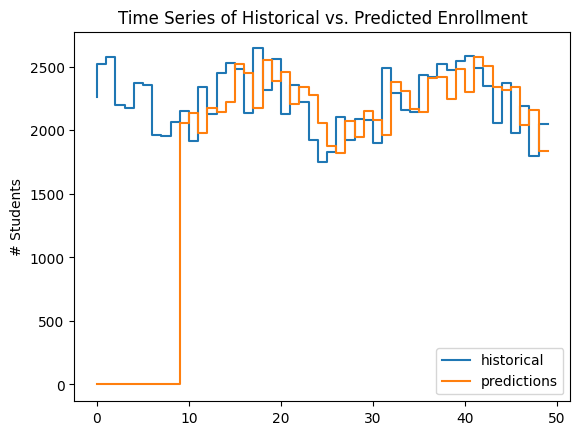

In [275]:
simSchool.plot_history_vs_preds()

In [276]:
simSchool.predictive_accuracy()

0.4205890022563795

## Plots: Predicted Student/School Ratios vs. Actuals

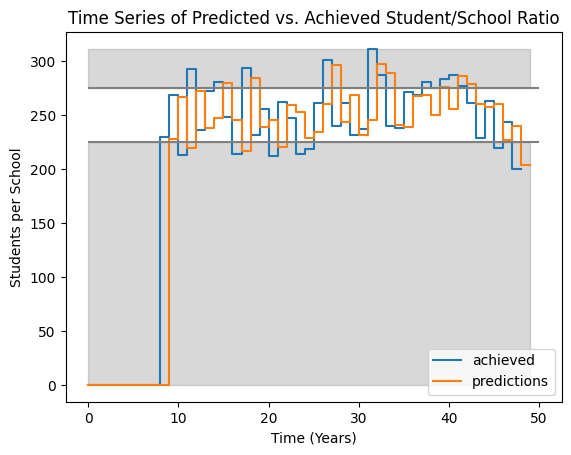

In [277]:
simSchool.plot_ratios()

In [278]:
simSchool.pct_when_performant(to_print=True)

The district was within tolerance bounds 54.0% of the time.


0.5384615384615384

## Plots: Trends in School Enrollment and Openings/Closings

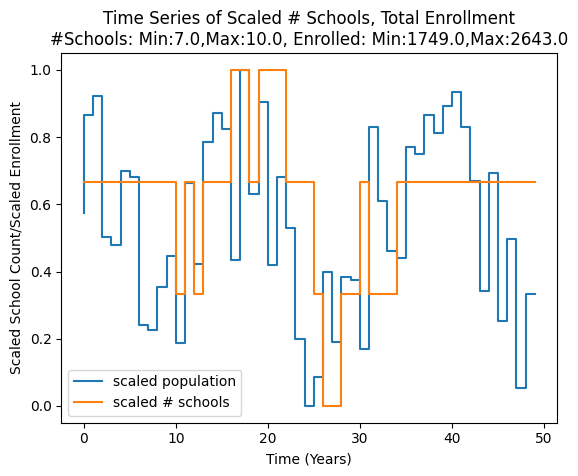

In [279]:
simSchool.plot_schools_vs_pop()

## Budget figures

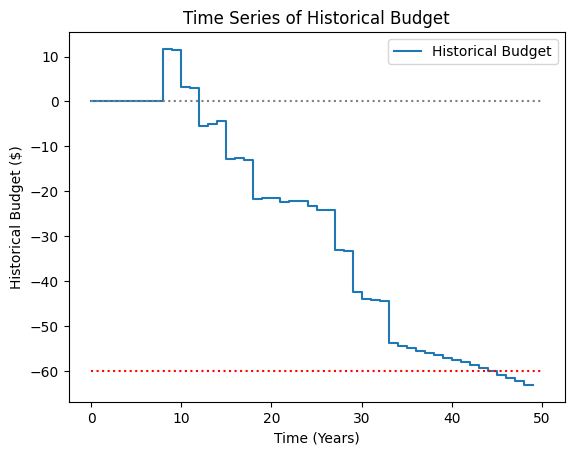

In [280]:
simSchool.plot_budget()

In [281]:
simSchool.pct_when_in_budget(lower_thresh=simSchool.school_minimum_threshold,to_print=True)

The district budget was above the threshold of $-60.0 88.0% of the time.


0.875

## Metrics: run lengths

In [282]:
runlength_stats(get_run_lengths([int(x) for x in simSchool.hist_schools]))

{'counts': Counter({11: 1, 1: 6, 3: 4, 2: 3, 15: 1}),
 'mean': 3.3333333333333335,
 'median': 2.0,
 'stddev': 3.944053188733077}

## Metrics: $\alpha$s

In [283]:
Counter(simSchool.hist_alphas)

Counter({0.0: 10,
         0.9: 13,
         0.30000000000000004: 1,
         0.7000000000000001: 1,
         0.5: 3,
         0.2: 1,
         0.8: 9,
         0.4: 3,
         0.6: 3,
         0.1: 6})

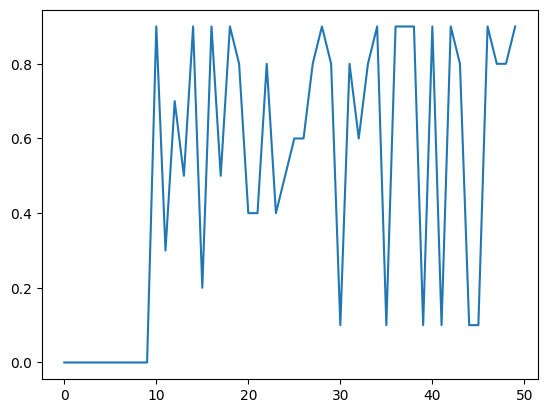

In [284]:
plt.plot(simSchool.hist_alphas)

# Factorial Experiment


In [285]:
def individual_replicate(SampleSize=3500,ratio=250, growth_patterns:list=[0,0,0], is_noisy:bool=False, alphas:tuple=None)->dict:
    simSchool = SchoolDistrict(NStudents=SampleSize, #Start with 1250 students
                               sscRat=ratio,  # ideal student/school ratio is 250
                               tolerance=(-.1,.1), #tolerate student/school ratios of 225 to 275
                               growth_period=50, # growth patterns last 20 years
                               n_periods=len(growth_patterns), # run for 60 years
                               noisy=is_noisy, # add noise to population change
                               school_minimum_threshold = -50., # minimum budget to open/close a school
                               school_fund_fraction=0.70, # determines how much over current school operating expenses to charge in taxes
                               interest_rate=0.02,
                               pred_ratios=[], ach_ratios=[], hist_alphas=[], predictions=[],hist_budget=[]
                           )
    if alphas is not None:
        simSchool.alphas = alphas
    school_results = {}
    simSchool.simulate_full_history(set_history=growth_patterns)
    simSchool.make_construction_decisions(debug=False)
    school_results['r2'] = simSchool.predictive_accuracy()
    school_results['pct_performant'] = simSchool.pct_when_performant(to_print=False)
    school_results['pct_budgetary'] = simSchool.pct_when_in_budget(lower_thresh=simSchool.school_minimum_threshold,to_print=False)
    school_results['decision_length'] = runlength_stats(get_run_lengths([int(x) for x in simSchool.hist_schools]))['median']
    return school_results

In [286]:
individual_replicate(growth_patterns=[0,1,3,1])

{'r2': 0.9778296681667257,
 'pct_performant': 0.14814814814814814,
 'pct_budgetary': 1.0,
 'decision_length': 4.0}

In [287]:
def run_experiment(growth_pat_len:int=3, noise:bool=False, set_alpha=None, plot:bool=True):
    alphas_ = tuple(set_alpha for x in range(23)) if set_alpha is not None else None
    exp_result = {}
    pprod = product("0123456", repeat=growth_pat_len)
    formula = "pct_performant ~ " + " + ".join([f"C(p{x})" for x in range(growth_pat_len)])
    # print(formula)
    for pat in pprod:
        local_name = ",".join(pat)
        growth_pats =  [int(y) for y in pat]
        # print(growth_pats)
        local_res = individual_replicate(growth_patterns =growth_pats, is_noisy=noise, alphas=alphas_)
        exp_result[local_name] = local_res

    factorial = pd.DataFrame(exp_result).T
    for _,j in enumerate(range(growth_pat_len)):
        factorial[f'p{_}'] = factorial.index.to_series().apply(lambda x: x.split(',')[_])

    if plot:
        factorial.boxplot(column='r2', by='p0')
        factorial.boxplot(column='pct_budgetary', by='p0')
        factorial.boxplot(column='pct_performant', by='p0')
        factorial.boxplot(column='decision_length', by='p0')
        factorial.plot.scatter('decision_length', 'pct_performant', c=[int(x) for x in factorial['p2']], colormap='Dark2',alpha=0.3 )


    print(factorial[['r2', 'pct_budgetary', 'pct_performant','decision_length']].describe())

    lm = ols(formula, factorial).fit()
    print(lm.summary())
    print(anova_lm(lm))
    return factorial, lm

In [288]:
@dataclass
class SingleExperiment:
    # Single run from one set of experimental conditions
    growth_pat_len:int=4
    noise:bool=False
    set_alpha:float=None
    plot:bool=False

    def run(self):
        self.name = f"gpl:{self.growth_pat_len};noise:{self.noise};A:{self.set_alpha}"
        self.result = run_experiment(growth_pat_len=self.growth_pat_len,
                       noise=self.noise, set_alpha=self.set_alpha, plot=self.plot)
        self.core_res = self.result[0][['r2', 'pct_budgetary', 'pct_performant','decision_length']].median()

    def get_result(self):
        self.run()
        return self.core_res


In [289]:
initial_class_test = SingleExperiment(growth_pat_len=3)
initial_class_test.get_result()

               r2  pct_budgetary  pct_performant  decision_length
count  343.000000     343.000000      343.000000       343.000000
mean     0.886008       0.904123        0.712398         5.145773
std      0.170787       0.185376        0.265706         6.294482
min      0.171246       0.307143        0.050360         1.000000
25%      0.892499       0.914286        0.496403         2.000000
50%      0.962844       1.000000        0.791367         3.000000
75%      0.981833       1.000000        0.964029         6.000000
max      0.999393       1.000000        1.000000        50.000000
                            OLS Regression Results                            
Dep. Variable:         pct_performant   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     42.70
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           2.68e-74
Time:      

,0
r2,0.962844
pct_budgetary,1.000000
pct_performant,0.791367
decision_length,3.000000


In [290]:
noisy_test = SingleExperiment(growth_pat_len=3,noise=True)
noisy_test.get_result()

               r2  pct_budgetary  pct_performant  decision_length
count  343.000000     343.000000      343.000000       343.000000
mean     0.804309       0.723136        0.432137         3.077259
std      0.212834       0.315833        0.210066         2.586912
min     -0.105518       0.135714        0.064748         1.000000
25%      0.745965       0.350000        0.266187         2.000000
50%      0.889591       0.971429        0.417266         2.000000
75%      0.948782       1.000000        0.575540         3.000000
max      0.987384       1.000000        0.920863        21.000000
                            OLS Regression Results                            
Dep. Variable:         pct_performant   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     38.66
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.48e-69
Time:      

,0
r2,0.889591
pct_budgetary,0.971429
pct_performant,0.417266
decision_length,2.000000


In [291]:
a01_test = SingleExperiment(set_alpha=0.1, growth_pat_len=3)
a01_test.get_result()

               r2  pct_budgetary  pct_performant  decision_length
count  343.000000     343.000000      343.000000       343.000000
mean     0.824667       0.984194        0.741783         8.835277
std      0.198180       0.095738        0.216206         4.912671
min     -0.033404       0.342857        0.079137         1.000000
25%      0.823138       1.000000        0.661871         4.750000
50%      0.891156       1.000000        0.776978         8.000000
75%      0.940528       1.000000        0.892086        11.500000
max      0.999963       1.000000        1.000000        21.000000
                            OLS Regression Results                            
Dep. Variable:         pct_performant   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     91.10
Date:                Thu, 05 Dec 2024   Prob (F-statistic):          5.88e-115
Time:      

,0
r2,0.891156
pct_budgetary,1.000000
pct_performant,0.776978
decision_length,8.000000


In [292]:
na01_test = SingleExperiment(growth_pat_len=3, set_alpha=0.1, noise=True)
na01_test.get_result()

Simulation terminated early. Zero schools left.
               r2  pct_budgetary  pct_performant  decision_length
count  343.000000     343.000000      343.000000       343.000000
mean     0.777715       0.982216        0.607813         7.061224
std      0.202485       0.092511        0.202584         4.094360
min     -0.189068       0.342857        0.079137         1.000000
25%      0.712643       1.000000        0.460432         3.500000
50%      0.854060       1.000000        0.654676         6.000000
75%      0.914624       1.000000        0.755396        10.500000
max      0.980648       1.000000        0.949640        20.500000
                            OLS Regression Results                            
Dep. Variable:         pct_performant   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     83.27
Date:                Thu, 05 Dec 2024   Pr

,0
r2,0.854060
pct_budgetary,1.000000
pct_performant,0.654676
decision_length,6.000000


In [293]:
a09_test = SingleExperiment(growth_pat_len=3, set_alpha=0.9)
a09_test.get_result()

Simulation terminated early. Zero schools left.
               r2  pct_budgetary  pct_performant  decision_length
count  343.000000     343.000000      343.000000       343.000000
mean     0.892720       0.944752        0.749451        12.798834
std      0.188534       0.149987        0.275216        11.069903
min     -0.006293       0.314286        0.064748         1.000000
25%      0.890964       1.000000        0.561151         3.000000
50%      0.980721       1.000000        0.863309        11.500000
75%      0.997373       1.000000        0.992806        16.250000
max      1.000000       1.000000        1.000000        57.000000
                            OLS Regression Results                            
Dep. Variable:         pct_performant   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     54.75
Date:                Thu, 05 Dec 2024   Pr

,0
r2,0.980721
pct_budgetary,1.000000
pct_performant,0.863309
decision_length,11.500000


               r2  pct_budgetary  pct_performant  decision_length
count  343.000000     343.000000      343.000000       343.000000
mean     0.777739       0.709933        0.379009         3.053936
std      0.243421       0.322052        0.193728         2.394409
min     -0.066888       0.142857        0.043165         1.000000
25%      0.701848       0.353571        0.230216         1.500000
50%      0.885812       0.964286        0.352518         2.000000
75%      0.956551       1.000000        0.482014         3.500000
max      0.988368       1.000000        0.892086        14.000000
                            OLS Regression Results                            
Dep. Variable:         pct_performant   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     34.48
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           2.67e-64
Time:      

,0
r2,0.885812
pct_budgetary,0.964286
pct_performant,0.352518
decision_length,2.000000


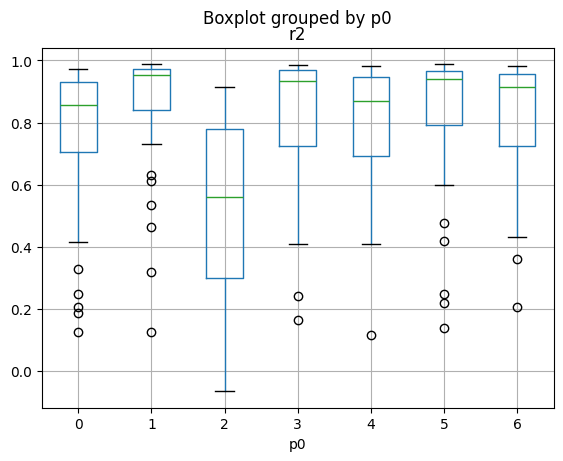

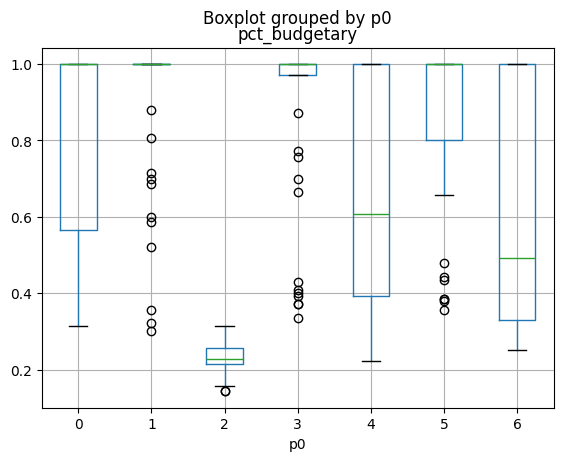

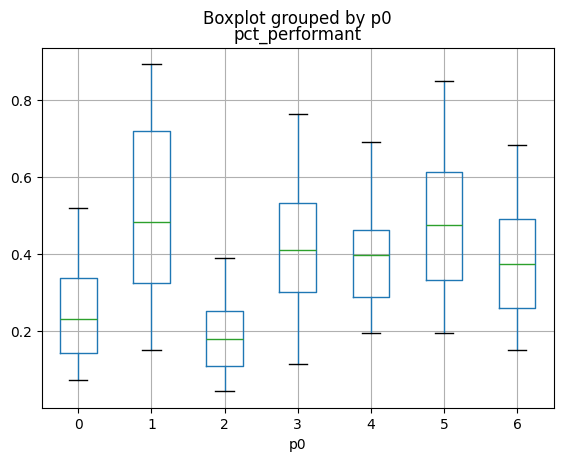

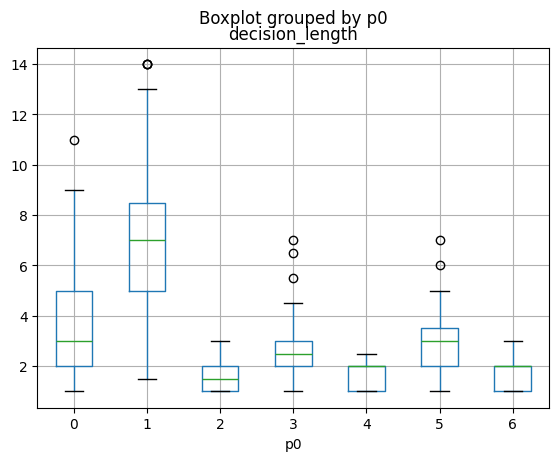

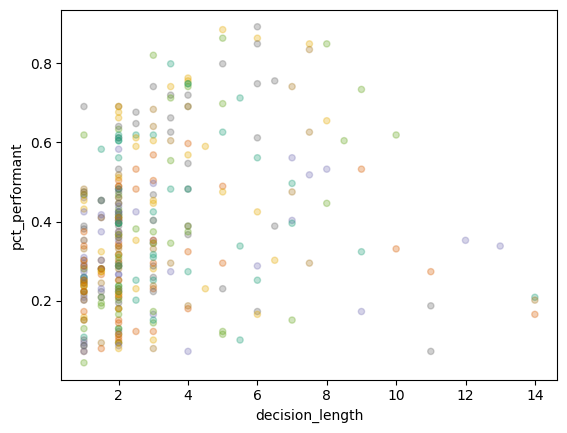

In [294]:
na09_test = SingleExperiment(growth_pat_len=3, set_alpha=0.9, noise=True,plot=True)
na09_test.get_result()

In [297]:
pd.DataFrame({x.name:x.core_res for x in [initial_class_test, noisy_test, a01_test, a09_test, na01_test, na09_test]}).T.sort_index()


,r2,pct_budgetary,pct_performant,decision_length
gpl:3;noise:False;A:0.1,0.891156,1.000000,0.776978,8.0
gpl:3;noise:False;A:0.9,0.980721,1.000000,0.863309,11.5
gpl:3;noise:False;A:None,0.962844,1.000000,0.791367,3.0
gpl:3;noise:True;A:0.1,0.854060,1.000000,0.654676,6.0
gpl:3;noise:True;A:0.9,0.885812,0.964286,0.352518,2.0
gpl:3;noise:True;A:None,0.889591,0.971429,0.417266,2.0


from matplotlib import pyplot as plt
_df_0['r2'].plot(kind='hist', bins=20, title='r2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['pct_budgetary'].plot(kind='hist', bins=20, title='pct_budgetary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['pct_performant'].plot(kind='hist', bins=20, title='pct_performant')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['decision_length'].plot(kind='hist', bins=20, title='decision_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='r2', y='pct_budgetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='pct_budgetary', y='pct_performant', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='pct_performant', y='decision_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['r2'].plot(kind='line', figsize=(8, 4), title='r2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['pct_budgetary'].plot(kind='line', figsize=(8, 4), title='pct_budgetary')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['pct_performant'].plot(kind='line', figsize=(8, 4), title='pct_performant')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['decision_length'].plot(kind='line', figsize=(8, 4), title='decision_length')
plt.gca().spines[['top', 'right']].set_visible(False)

In [296]:
initial_class_test.name

'gpl:3;noise:False;A:None'

# Discounting and predictive accuracy
- In benefit-cost analysis, the process of discounting involves converting "each future dollar \[or util\] amount into equivalent future dollars" (Weitzman, 2001),
- Discounting depends on a 'discount rate' $d$ a number, generally between 0 and 1, that reflects the proportion by which money would have to grow annually for an agent to be indifferent between having money now and having money in the future; a discount rate of 5\% means that an agent considers receiving a benefit of \\$100 now to be equivalent with one of \\$105, received in one year.
- A high discount rate corresponds to an expected low value of money in the future relative to now, and can reflect uncertainty.
- The higher the discount rate, the less important predictive accuracy is to decision-making*: if the discount rate is such that the required future value is much greater than the predictive accuracy, there is no point in predicting--future money is so worthless to the agent . For example, in an autoregressive predictive model, say that $y_{t+1} = \beta y_t + \varepsilon$, where $0<\beta<1$ and $\varepsilon$ is Gaussian with mean 0 and variance 1; then, if $d = 11$,  the prediction cannot help the agent make a decision.

* for models that don't extrapolate beyond existing data or that have narrow bounds on their trends.

# Future Directions
- Common Core of Data API
- Gittins index agents
- Process controllers (PID, feed-forward, ...?)

# Test Functions
- all that's needed for testing to make sense is that the shape of the prediction match the shape of the growth curve--I think I can use the FTES or other theory to show that smooth transitions can be well-followed and that EWMA should be able to be useful for maintaining a ratio.

Key questions:
- Are there "close" conditions under which predictive accuracy makes the difference between success and failure?
- Is there an empirical relationship between discounting and predictive accuracy?
- Does scaling make a difference?